# Natural Actor-Critic (Peters & Schaal 2007)

Actor critic is a reinforcement learning algorithm composed of two parts, the actor and the critic. The actor is a policy in charge of selecting actions based on the current state and the critic must learn the value of the policy. The actor then uses the critic's learned values to update its own policy. Once the actor is updated, the critic must learn the values of the new policy, creating a co-dependent cycle until both converge.

Actor-critic methods often uses gradient descent (or ascent) to perform the learning updates. However, gradient descent can be inefficient, taking small steps on plateau's or taking steps in directions which seem optimal in the first-order, but aren't in the second.

Natural gradients are a reweighting of the first order gradients which changes the gradient from being the speedest descent in the parameter space to the steepest descent in the fisher information space. This is done by reweighting the gradient as $\tilde\nabla_\theta J(\theta) = G^{-1}(\theta)\nabla_\theta J(\theta)$, where $G(\theta)$ is the fisher information matrix.

The Fisher information matrix is given by the outer product of the gradient vector of the log likelihood, $G(\theta) = \nabla_\theta(\log P(\theta))\nabla_\theta(\log P(\theta))^T$.

Now, to update the actor in actor-critic methods, we use the policy gradient method, given by $\nabla_\theta(J(\theta)) = \mathbb{E}_{d^\pi(s)}\sum_{a \in \mathbb{A}}\nabla_\theta \pi(a|s)Q^\pi(a,s)$. We can then perform the log trick to give us $\nabla_\theta(J(\theta)) = \mathbb{E}_{d^\pi(s)}\nabla_\theta \log\pi(a|s)Q^\pi(a,s)$

Lastly, we will use compatible features as the inputs to the Q-value as opposed the simply inputting the state. The Q-value is given by $Q(s,a) = \phi(s,a)^T w$, where $\phi(s,a) = \nabla_\theta \log \pi(a|s)$. Note that this value function is mean-zero with regards to the action distribution as $\sum_{a \in A}\pi(a|s)Q_w(a,s) = \sum_{a \in A}\pi(a|s)\nabla_\theta\log \pi(a|s)w = w \sum_{a \in A} \nabla_\theta \pi(a|s) = w \nabla_\theta \sum_{a \in A} \pi(a|s) = w \nabla_\theta 1 = 0$. This means the Q function with  compatible features is really an advantage function. We then have to add the state value to our function approximation to give us Q-values.

Putting all of these together, we can update the policy gradient as follows.

$\tilde \nabla_\theta(J(\theta)) = \mathbb{E}_{d^\pi(s)} (\nabla_\theta(\log \pi(a|s))\nabla_\theta(\log \pi(a|s))^T)^{-1} \nabla_\theta \log\pi(a|s)((\nabla_\theta \log \pi(a|s))^T w) = w$

As to create a concrete algorithm for this, we simply have to update the parameter $w$ until it converges for the current policy, then update the actor with the simple policy update.

The following code runs the episodic natural actor-critic (eNAC) on the cartpole environment.

[2017-04-15 18:18:11,830] Making new env: CartPole-v0


compiling


/Users/jeanharb/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:48: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.


compiled
121 0.9308847604533497 16
133 0.9295050475835348 14
137 0.2075319042811512 21
142 0.39033067491776213 21
144 0.016777611690430766 18
149 0.5394578703325077 16
152 0.5377118018948868 24
158 0.00014492952608216188 22
163 0.00014360264180113543 16
173 0.12761818924183163 22
175 0.4101044177354037 15
179 0.4585589759213039 25
180 0.9572366425333441 28
181 0.24407045678358316 25
183 0.11695383060937278 20
184 0.4512970521613907 18
187 0.17472923014008032 16
188 0.40366271060554193 22
192 0.5130158680439867 17
193 0.08223721286558151 21
195 0.14177040281787154 20
197 0.353693648126504 26
199 0.4313271511794836 14
208 0.052364733204939264 20
212 0.355025717855401 22
215 0.30027704581946796 22
217 0.07720366914620497 19
219 0.012219825246946455 11
222 0.756921667366237 11
223 0.38181088603375035 19
226 0.17236341987224219 10
229 0.07129424942611214 19
232 0.33592654898442664 15
233 0.002264483087390796 17
238 0.0037861186050065273 20
239 0.8210565649510027 10
240 0.03994462065355417 9

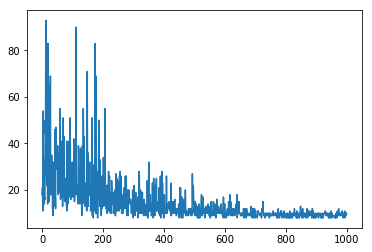

In [6]:
import matplotlib.pyplot as plt
import time
import gym
import numpy as np
import theano
import theano.tensor as T

env = gym.make("CartPole-v0")

ob_space = env.observation_space.shape[0]
a_space = env.action_space.n
lr = 0.01
gamma = 0.95

x = T.fmatrix()
a = T.ivector()
adv = T.fscalar()

w = theano.shared(np.random.rand((ob_space+1),a_space))
#w_b = theano.shared(np.zeros((a_space,)))
theta_w = theano.shared(np.random.rand(ob_space, a_space))
theta_b = theano.shared(np.zeros((a_space,)))
#theta = T.concatenate([theta_w, theta_b.dimshuffle('x', 0)], axis=0)

policy = T.nnet.softmax(T.dot(x, theta_w)+theta_b)
policy_a = policy[T.arange(a.shape[0]), a]

log_grads = theano.gradient.jacobian(T.log(policy_a), [theta_w, theta_b])
w_log_grads = T.reshape(log_grads[0], [x.shape[0], ob_space*a_space])
b_log_grads = T.reshape(log_grads[1], [x.shape[0], a_space])
log_grads = T.concatenate([w_log_grads, b_log_grads], axis=1)

A_vals = T.sum(log_grads*w.flatten().dimshuffle(['x', 0]), axis=1)
discounted_A = T.sum(T.power(np.float32(gamma), T.arange(A_vals.shape[0]))*A_vals)


new_theta_b = theta_b + lr*w[-1,:]
new_theta_w = theta_w + lr*w[:-1,:]

cost = T.sqr(discounted_A-adv)
w_grad = T.grad(cost, w)

print("compiling")
softmax = theano.function([x], policy)
get_logs = theano.function([x, a], log_grads)
new_w = w - w_grad*lr
update_w = theano.function([x,a,adv], [new_w, cost, w_grad, log_grads], updates={w:new_w})
update_theta = theano.function([], [], updates={theta_w: new_theta_w, theta_b:new_theta_b})

print("compiled")

V_estimate = 0
move_count = []
for i in range(1000):
    obs = env.reset()
    done = False
    actions = []
    states = []
    rewards = []
    num_moves = 0
    while not done:
        probs = softmax(np.array([obs]).astype("float32"))[0]
        a = np.random.choice(a_space, 1, p=probs)[0]
        states.append(obs)
        actions.append(a)
        obs, r, done, info = env.step(a)
        rewards.append(-r)
        num_moves +=1
        #print(probs, a, obs, r, done, info)s
    move_count.append(num_moves)
    #update value and critic
    R = (np.power(gamma, np.arange(len(rewards)))*np.array(rewards)).sum()
    V_update = R-V_estimate
    up_w = update_w(np.array(states).astype("float32"), np.array(actions).astype("int32"), np.float32(V_update))
    V_estimate += lr*V_update
    # if w cost is low, w is converged. then update theta
    if up_w[1] < 1:
        update_theta()
        print(i, up_w[1], num_moves)

plt.plot(move_count)
plt.show()
